**TODO: put (parts of) this into paper and/or README.**

How parameter tuning works in our case:

Each evaluator has one or two numerical parameters that can be "tuned" in order to minimize a certain error. However, we have no mathematical model that can be trained in the classical ML sense. Instead, for every service, we try parameters from a parameter grid and consider this as "training" or "tuning".

We train the parameters using a 5-fold cross validation and report the average error on the test sets as the optimal error that can be achieved.

To make the tuning comparable across services, we build the parameter grids based on quantiles of the distributions of the tuning parameters. For every service and parameter we use a maximum of 20 parameter values as a default. (Note that depending on the distribution the number of the resulting parameter values can be less than 20.) For this step we consider only those responses where the API/service decided for 'f' or 'm' (so we ignore 'unknown' or similar). 

Finally, we train each evaluator on the entire data set to obtain the best parameter values for a given error.

In [1]:
import pandas as pd
import numpy as np
from evaluators import *
from evaluator import *
from helpers import REGISTERED_EVALUATORS, compute_equal_frequency_binning

import matplotlib.ticker as mtick
from mpltools import style
style.use('ggplot')
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import ParameterSampler

import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'style']
`%matplotlib` prevents i

## Compute errors without tuning

In [2]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['error_with_unknown', 'error_without_unknown', 'error_gender_bias', 'error_unknown', 
                  'weighted_error','f_precision', 'f_recall']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [3]:
compute_all_errors_without_tuning()

,error_with_unknown,error_without_unknown,error_gender_bias,error_unknown,weighted_error,f_precision,f_recall
namsor,0.135924,0.051384,0.010049,0.089119,0.069590,0.911184,0.938453
names_api_full,0.186874,0.043284,0.007112,0.150086,0.075921,0.927865,0.947150
names_api,0.237997,0.050161,0.010549,0.197755,0.094789,0.918308,0.945140
gender_api_full,0.204145,0.077108,-0.019027,0.137651,0.105659,0.911043,0.860870
gender_api,0.086701,0.058405,-0.008191,0.030052,0.064203,0.924559,0.902350
gender_guesser,0.229361,0.035243,0.005405,0.201209,0.081515,0.941360,0.956274
genderize_io,0.150432,0.058925,0.025253,0.097237,0.078770,0.886715,0.951381


## Plot distributions of the tuning parameters

Seaborn does not work with matplotlib subplots and its own grids are not applicable here. Matplotlib on the other hand has no good plots of bivariate distributions. Hence plotting each of the seven distributions separately...

In [4]:
def plot_distribution_of_tuning_param(e):
    evaluator = e('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_data_for_parameter_tuning()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
    
    tuning_params = list(evaluator.tuning_params)
    if len(tuning_params) == 1:
        sns.distplot(evaluator.test_data[tuning_params], kde=False)
    else:
        param_1, param_2 = tuning_params[0], tuning_params[1]
        sns.jointplot(x=param_1, y=param_2, data=evaluator.test_data[tuning_params])

gender_api


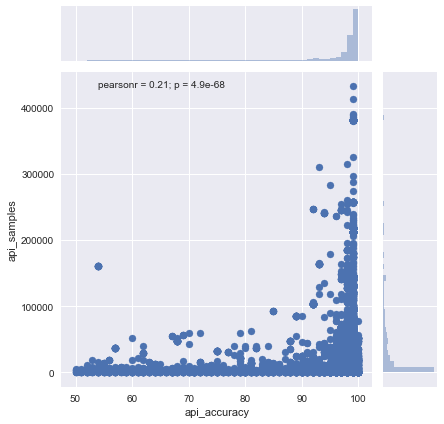

In [5]:
e = REGISTERED_EVALUATORS[0]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

gender_api_full


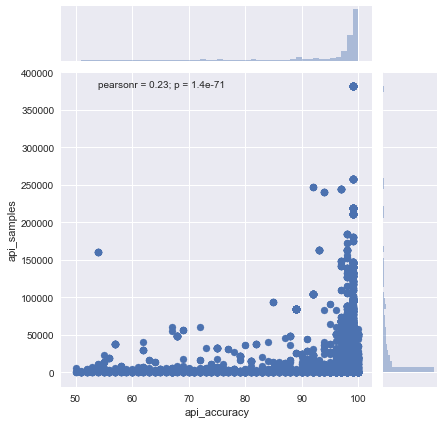

In [6]:
e = REGISTERED_EVALUATORS[1]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

names_api


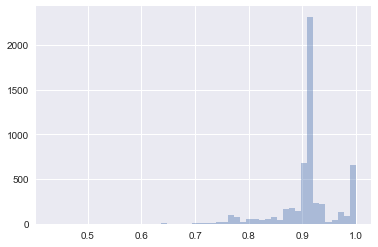

In [7]:
e = REGISTERED_EVALUATORS[2]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

names_api_full


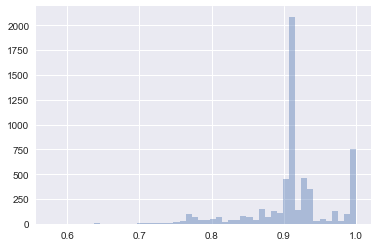

In [8]:
e = REGISTERED_EVALUATORS[3]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

namsor


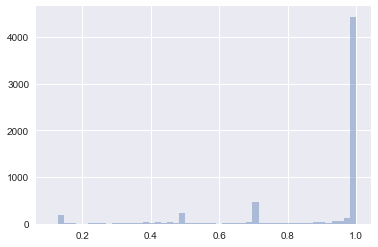

In [9]:
e = REGISTERED_EVALUATORS[4]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

gender_guesser


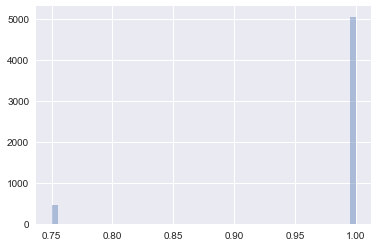

In [10]:
e = REGISTERED_EVALUATORS[5]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

genderize_io


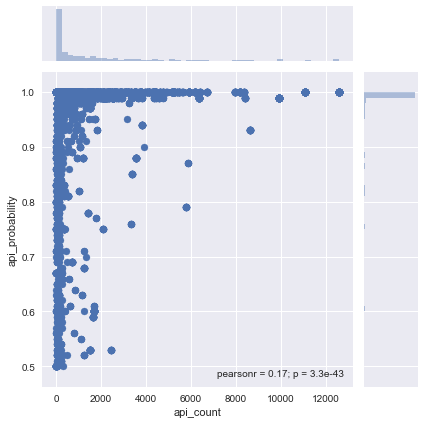

In [11]:
e = REGISTERED_EVALUATORS[6]
print(e.gender_evaluator)
plot_distribution_of_tuning_param(e)

## Discretize distribution of tuning parameters via random sampling

Example from scikit-learn docstring

In [12]:
from scipy.stats.distributions import expon
import numpy as np
np.random.seed(0)
param_grid = {'a':[1, 2], 'b': expon()}
param_list = list(ParameterSampler(param_grid, n_iter=4))
rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items()) for d in param_list]

rounded_list

[{'a': 1, 'b': 0.89856000000000003},
 {'a': 1, 'b': 0.92322300000000002},
 {'a': 2, 'b': 1.8789640000000001},
 {'a': 2, 'b': 1.0381590000000001}]

## Build parameter grids for all services

In [36]:
def build_parameter_grid(e, n_iter=20, method='square'):
    """method is either 'square' or 'constant'"""
    tuning_params = list(e.tuning_params)

    param_grid = {}
    for param in tuning_params:
        param_grid[param] = e.test_data[param].values
    
    if method=='square':
        n_params = n_iter**len(tuning_params)
    else:
        n_params=n_iter

    param_list = list(ParameterSampler(param_grid, n_iter=n_params, random_state=0))
    zero_el = {k:0 for k in param_list[0].keys()}
    param_list = [dict(t) for t in set([tuple(d.items()) for d in param_list])] + [zero_el] # deduplicate and add zero element
    param_grid = [dict((k, round(v, 6)) for (k, v) in d.items()) for d in param_list]
    
    return param_grid


In [37]:
s = REGISTERED_EVALUATORS[0]
evaluator = s('all')
eval_name = evaluator.gender_evaluator
evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator._translate_api_response()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

build_parameter_grid(evaluator, n_iter=3)

[{'api_accuracy': 98, 'api_samples': 8496},
 {'api_accuracy': 76, 'api_samples': 139211},
 {'api_accuracy': 56, 'api_samples': 95042},
 {'api_accuracy': 99, 'api_samples': 52754},
 {'api_accuracy': 58, 'api_samples': 12},
 {'api_accuracy': 99, 'api_samples': 1772},
 {'api_accuracy': 99, 'api_samples': 9249},
 {'api_accuracy': 99, 'api_samples': 14681},
 {'api_accuracy': 99, 'api_samples': 1530},
 {'api_accuracy': 0, 'api_samples': 0}]

In [38]:
def build_grid_for_all_services(n_iter=20, method='square'):
    service_to_grid_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_data_for_parameter_tuning()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        
        service_to_grid_range[evaluator.gender_evaluator] = build_parameter_grid(evaluator, n_iter=n_iter, 
                                                                                 method=method)
        
    return service_to_grid_range

In [43]:
grid_20_20 = build_grid_for_all_services(n_iter=20, method="constant")
grid_30_30 = build_grid_for_all_services(n_iter=30, method="constant")
grid_50_50 = build_grid_for_all_services(n_iter=50, method="constant")
grid_100_100 = build_grid_for_all_services(n_iter=100, method="constant")
grid_200_200 = build_grid_for_all_services(n_iter=200, method="constant")

grid_20_400 = build_grid_for_all_services(n_iter=20, method="square")

In [50]:
# check size of grid per service
dict_of_grids = {"a: 20-20": grid_20_20, "b: 30-30": grid_30_30, "c: 50-50": grid_50_50, 
                             "d: 100-100": grid_100_100, "e: 200-200": grid_200_200, "f: 20-400": grid_20_400}

dict_of_grids = OrderedDict(sorted(dict_of_grids.items(), key=lambda t: t[0]))

for grid_size, service_to_grid in dict_of_grids.items():
    print(grid_size)
    for service, grid in service_to_grid.items():
        print(service, len(grid))

a: 20-20
namsor 5
names_api_full 14
names_api 16
gender_api_full 21
gender_api 21
gender_guesser 3
genderize_io 21
b: 30-30
namsor 7
names_api_full 17
names_api 23
gender_api_full 31
gender_api 31
gender_guesser 3
genderize_io 31
c: 50-50
namsor 10
names_api_full 26
names_api 33
gender_api_full 51
gender_api 51
gender_guesser 3
genderize_io 50
d: 100-100
namsor 22
names_api_full 45
names_api 46
gender_api_full 100
gender_api 99
gender_guesser 3
genderize_io 98
e: 200-200
namsor 30
names_api_full 84
names_api 77
gender_api_full 195
gender_api 195
gender_guesser 3
genderize_io 179
f: 20-400
namsor 5
names_api_full 14
names_api 16
gender_api_full 384
gender_api 379
gender_guesser 3
genderize_io 326


We see the following:

* for `gender_guesser` there are at most 3 parameter values anyway so exhaustive search of parameter space is reached
* the `namsor` parameter space is quite sparse, hence the grid size does not grow as fast; the other 1-parameter service `names_api` (and `names_api_full`) profits more
* the grid sizes for the 2-parameter services `gender_api` (and `gender_api_full`) and `genderize_io` grow almost to the limit of the allowed grid size

In [23]:
grid_20_20['gender_api']

[{'api_accuracy': 98, 'api_samples': 75},
 {'api_accuracy': 99, 'api_samples': 15153},
 {'api_accuracy': 62, 'api_samples': 14178},
 {'api_accuracy': 99, 'api_samples': 32139},
 {'api_accuracy': 99, 'api_samples': 211741},
 {'api_accuracy': 99, 'api_samples': 1778},
 {'api_accuracy': 100, 'api_samples': 66},
 {'api_accuracy': 97, 'api_samples': 110176},
 {'api_accuracy': 97, 'api_samples': 1355},
 {'api_accuracy': 99, 'api_samples': 2162},
 {'api_accuracy': 97, 'api_samples': 163073},
 {'api_accuracy': 92, 'api_samples': 29790},
 {'api_accuracy': 97, 'api_samples': 52197},
 {'api_accuracy': 99, 'api_samples': 7151},
 {'api_accuracy': 97, 'api_samples': 1689},
 {'api_accuracy': 99, 'api_samples': 95042},
 {'api_accuracy': 99, 'api_samples': 145540},
 {'api_accuracy': 99, 'api_samples': 121},
 {'api_accuracy': 99, 'api_samples': 6622},
 {'api_accuracy': 60, 'api_samples': 12597},
 {'api_accuracy': 0, 'api_samples': 0}]

In [24]:
grid_20_20['gender_guesser']

[{'confidence': 1.0}, {'confidence': 0}]

### Test the effect of parameters for grid creation using one error function

In [51]:
# Wrapper around some methods to make tuning with different error functions a one-liner
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_data_for_parameter_tuning()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

def tune(error_func, grids, constraint_func=None, constraint_val=None):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)
        
        grid = grids[evaluator_name]
        mean_test_error = evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=error_func, 
                                                    constraint_func=constraint_func, constraint_val=constraint_val)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

#### 20 Parameter values for every service

In [52]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_20_20, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0922047074066 corresponding test error: 0.0923209663503
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.108160621762 corresponding test error: 0.101899827288
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.105354058722 corresponding test error: 0.113126079447
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.105354058722 corresponding test error: 0.113126079447
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.107058061731 corresponding test error: 0.106309420916
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
Average test error: 0.10535647469
gender_api_full
minimal train error: 0.263873893328 corresponding test error: 0.244176013805
params for lowest train error: {'api_samples': 69588, 'api_accuracy': 78}
minimal train error: 0.26057858

#### 30 Parameter values for every service

In [53]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_30_30, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0922047074066 corresponding test error: 0.0923209663503
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.102979274611 corresponding test error: 0.0975820379965
params for lowest train error: {'api_samples': 3438, 'api_accuracy': 66}
minimal train error: 0.105354058722 corresponding test error: 0.113126079447
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.105354058722 corresponding test error: 0.113126079447
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.107058061731 corresponding test error: 0.106309420916
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
Average test error: 0.104492916832
gender_api_full
minimal train error: 0.263873893328 corresponding test error: 0.244176013805
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train error: 0.2605785

#### 50 Parameter values for every service

In [54]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_50_50, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0922047074066 corresponding test error: 0.0923209663503
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.0988773747841 corresponding test error: 0.0915371329879
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.0980138169257 corresponding test error: 0.0949913644214
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.105354058722 corresponding test error: 0.113126079447
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.107058061731 corresponding test error: 0.106309420916
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
Average test error: 0.0996569928246
gender_api_full
minimal train error: 0.263873893328 corresponding test error: 0.244176013805
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train error: 0.26

#### 100 Parameter values for every service

In [55]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_100_100, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0922047074066 corresponding test error: 0.0923209663503
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.0988773747841 corresponding test error: 0.0915371329879
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.0980138169257 corresponding test error: 0.0949913644214
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.103626943005 corresponding test error: 0.116580310881
params for lowest train error: {'api_samples': 955, 'api_accuracy': 77}
minimal train error: 0.106842218865 corresponding test error: 0.103716508211
params for lowest train error: {'api_samples': 955, 'api_accuracy': 77}
Average test error: 0.0998292565703
gender_api_full
minimal train error: 0.259123299503 corresponding test error: 0.241587575496
params for lowest train error: {'api_samples': 140849, 'api_accuracy': 76}
minimal train error: 0.25021

#### 200 Parameter values for every service

In [56]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_200_200, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0902612826603 corresponding test error: 0.0914581535807
params for lowest train error: {'api_samples': 16868, 'api_accuracy': 54}
minimal train error: 0.0949913644214 corresponding test error: 0.0898100172712
params for lowest train error: {'api_samples': 42667, 'api_accuracy': 57}
minimal train error: 0.0980138169257 corresponding test error: 0.0949913644214
params for lowest train error: {'api_samples': 12597, 'api_accuracy': 60}
minimal train error: 0.100820379965 corresponding test error: 0.108808290155
params for lowest train error: {'api_samples': 1593, 'api_accuracy': 71}
minimal train error: 0.103604575869 corresponding test error: 0.0976663785653
params for lowest train error: {'api_samples': 1593, 'api_accuracy': 71}
Average test error: 0.0965468407988
gender_api_full
minimal train error: 0.259123299503 corresponding test error: 0.241587575496
params for lowest train error: {'api_samples': 140849, 'api_accuracy': 76}
minimal train error: 0.23

#### 20 parameter values per parameter but quadratic

In [57]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_20_400, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0902612826603 corresponding test error: 0.0914581535807
params for lowest train error: {'api_samples': 16310, 'api_accuracy': 54}
minimal train error: 0.0949913644214 corresponding test error: 0.0898100172712
params for lowest train error: {'api_samples': 42667, 'api_accuracy': 57}
minimal train error: 0.0971502590674 corresponding test error: 0.094127806563
params for lowest train error: {'api_samples': 6888, 'api_accuracy': 60}
minimal train error: 0.100172711572 corresponding test error: 0.107944732297
params for lowest train error: {'api_samples': 8120, 'api_accuracy': 64}
minimal train error: 0.097129289877 corresponding test error: 0.0968020743302
params for lowest train error: {'api_samples': 211741, 'api_accuracy': 58}
Average test error: 0.0960285568084
gender_api_full
minimal train error: 0.258259555172 corresponding test error: 0.240724762726
params for lowest train error: {'api_samples': 13218, 'api_accuracy': 78}
minimal train error: 0.236

## Below is old; needs to be repeated (and partially deleted)

## Benchmark (with `grid_20`)

## Errors from `genderizeR` paper

In [19]:
error_with_unknown = tune(Evaluator.compute_error_with_unknown, grid_20)

gender_api
minimal train error: 0.0870222414165 corresponding test error: 0.0854184641933
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0870034542314 corresponding test error: 0.0854922279793
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0865716753022 corresponding test error: 0.087219343696
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0861398963731 corresponding test error: 0.0898100172712
params for lowest train error: {'api_accuracy': 54, 'api_samples': 41}
minimal train error: 0.0867688322901 corresponding test error: 0.0864304235091
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
Average test error: 0.0868740953298
gender_api_full
minimal train error: 0.204059598359 corresponding test error: 0.204486626402
params for lowest train error: {'api_accuracy': 53, 'api_samples': 8}
minimal train error: 0.20207253886 corres

**Best result is achieved by `gender_api` with an average test error 0.0867013837581. Second best is `namsor` with 0.135923449219. All services achieve their best result at or near the left boundary of the parameter grid.**

In [18]:
error_without_unknown = tune(Evaluator.compute_error_without_unknown, grid_20)

gender_api
minimal train error: 0.0081053698075 corresponding test error: 0.00980392156863
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.0095525389643 corresponding test error: 0.0040404040404
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00800800800801 corresponding test error: 0.0102880658436
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00847457627119 corresponding test error: 0.00836820083682
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00812595226003 corresponding test error: 0.00970873786408
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
Average test error: 0.00844186603071
gender_api_full
minimal train error: 0.0158615717376 corresponding test error: 0.0193637621024
params for lowest train error: {'api_accuracy': 97.0, 'a

**Best result is achieved by `gender_api` with an average test error 0.00844186603071. Second best is `namsor` with 0.0166385626826. Several other services follow with very low errors as well. All services achieve their best result at or near the right boundary of the parameter grid.**

In [19]:
error_unknown = tune(Evaluator.compute_error_unknown, grid_20)

gender_api
minimal train error: 0.0291513711941 corresponding test error: 0.0336496980155
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0300086355786 corresponding test error: 0.0302245250432
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0304404145078 corresponding test error: 0.0284974093264
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0302245250432 corresponding test error: 0.0293609671848
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0304338441615 corresponding test error: 0.028522039758
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
Average test error: 0.0300509278656
gender_api_full
minimal train error: 0.136687540488 corresponding test error: 0.141501294219
params for lowest train error: {'api_accuracy': 0, 'api_samples': 5041.0}
minimal train error: 0.134283246

**Best result is achieved by `gender_api` with an average test error 0.0300509278656. Second best is `namsor` with 0.0891206876941. All services achieve their best result at or near the left boundary of the parameter grid.**

## Weighted error

This is a version of `error_with_unknown` where we put a weight of 0.2 on the names with true gender being 'f' or 'm' but classified as 'unknown'.

In [21]:
weighted_error = tune(Evaluator.compute_weighted_error, grid_20)

gender_api
minimal train error: 0.0526142096082 corresponding test error: 0.0514200853908
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0532586174421 corresponding test error: 0.0488623647893
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0512471867967 corresponding test error: 0.0569259962049
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0515299418059 corresponding test error: 0.0557655954631
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0532169505843 corresponding test error: 0.048969559463
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
Average test error: 0.0523887202622
gender_api_full
minimal train error: 0.0958408679928 corresponding test error: 0.0950639853748
params for lowest train error: {'api_accuracy': 72.0, 'api_samples': 

**Best result is achieved by `gender_api` with an average test error 0.0523887202622. Second best is `namsor` with 0.0640116391787. Several other services follow with very low errors as well.** 


## Minimize `error_with_unknown` with a constraint on the maximal value of `error_without_unknown`

In [22]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_20, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0902612826603 corresponding test error: 0.0871440897325
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 82.0}
minimal train error: 0.0949913644214 corresponding test error: 0.0915371329879
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 1208.0}
minimal train error: 0.0993091537133 corresponding test error: 0.105354058722
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 4788.0}
minimal train error: 0.0990932642487 corresponding test error: 0.10621761658
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 4788.0}
minimal train error: 0.102741204403 corresponding test error: 0.100259291271
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 10383.0}
Average test error: 0.0981024378586
gender_api_full
minimal train error: 0.256748002591 corresponding test error: 0.243313201035
params for lowest train error: {'api_accuracy': 81.0, 'api_samples': 3415.800000000000

**Best result is achieved by `gender_api` with an average test error 0.0981024378586. Second best is `namsor` with 0.154399563909.** 


---------------------

## TODO: Compute best parameter values for entire dataset

In [23]:
# TODO: fix this function. it should iterate through errors instead of evaluators. ANd return DataFrame.
def find_best_params_per_service(error_func, grids):
    service_to_error = {} # this is a stupid name but don't want to overwrite above
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)

        grid_range = grids[evaluator_name]
        grid = evaluator.build_parameter_grid(*grid_range)
        index = evaluator.test_data.index

        error = evaluator.compute_error_for_param_grid(param_grid=grid, error_func=error_func, index=index)
        service_to_error[evaluator_name] = error
    return service_to_error

## TODO: have a closer look into the wrong classifications